<a href="https://colab.research.google.com/github/JYJJEON/AIFFEL_Online_Quest/blob/main/Project/Project04(Deeplearning%20CV)/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EC%BB%B4%ED%93%A8%ED%84%B0_%EB%B9%84%EC%A0%84_CR5_Project_01_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [3]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

In [4]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [6]:
# 문제 1-2. hyperparameter 설정
# [[YOUR CODE]]
batch_size = 16
epochs = 100
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [7]:
# 문제 1-2. 데이터 generator 생성
# [[YOUR CODE]]
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# 문제 1-2. 모델 구현
# [[YOUR CODE]]
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_WIDTH,IMG_HEIGHT) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [9]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
# [[YOUR CODE]]
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=['binary_accuracy'])

es = EarlyStopping(monitor='val_loss', verbose = 1, patience = 5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [10]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=[es,mc],
      validation_freq=1)

Epoch 1/100
125/125 [==============================] - 171s 1s/step - loss: 1.9899 - binary_accuracy: 0.8455 - val_loss: 0.9648 - val_binary_accuracy: 0.9290
Epoch 2/100
125/125 [==============================] - 167s 1s/step - loss: 0.6264 - binary_accuracy: 0.9520 - val_loss: 0.4307 - val_binary_accuracy: 0.9680
Epoch 3/100
125/125 [==============================] - 201s 2s/step - loss: 0.4828 - binary_accuracy: 0.9645 - val_loss: 0.4215 - val_binary_accuracy: 0.9700
Epoch 4/100
125/125 [==============================] - 203s 2s/step - loss: 0.9353 - binary_accuracy: 0.9320 - val_loss: 0.3845 - val_binary_accuracy: 0.9740
Epoch 5/100
125/125 [==============================] - 202s 2s/step - loss: 0.5201 - binary_accuracy: 0.9600 - val_loss: 0.3770 - val_binary_accuracy: 0.9710
Epoch 6/100
125/125 [==============================] - 213s 2s/step - loss: 0.6729 - binary_accuracy: 0.9515 - val_loss: 0.2926 - val_binary_accuracy: 0.9810
Epoch 7/100
125/125 [==============================]

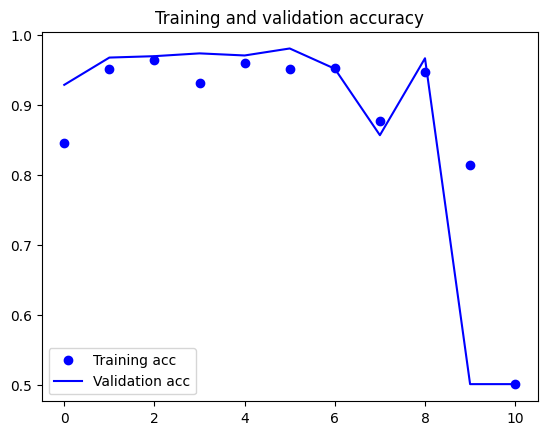

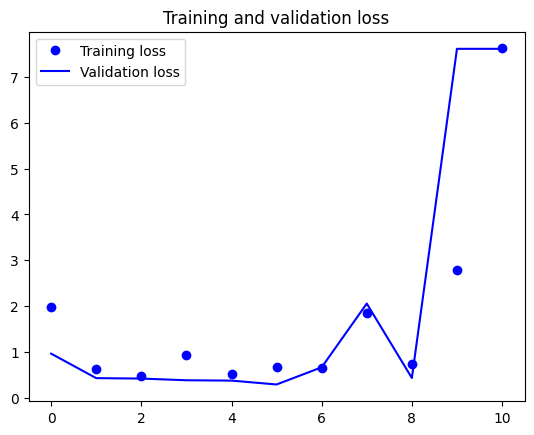

In [12]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()